In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator



Data Extraction from Dataset

In [24]:
# Load the dataset
data, info = tfds.load('colorectal_histology', with_info=True)

# Print available splits
print(info.features)



FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(150, 150, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=8),
})


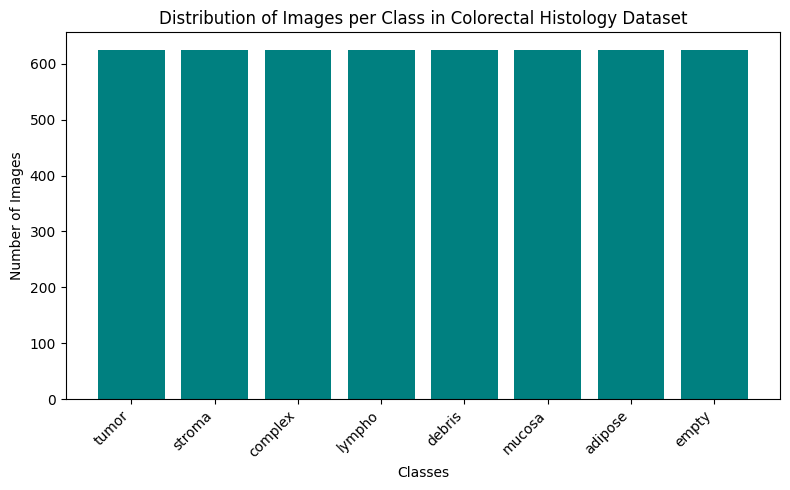

In [25]:
train_data = data['train']

# Extract label names
class_names = info.features['label'].names

# Count number of images per class
label_counts = {i: 0 for i in range(len(class_names))}

for sample in tfds.as_numpy(train_data):
    label_counts[sample['label']] += 1

# Plot
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_names)), label_counts.values(), color='teal')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class in Colorectal Histology Dataset')
plt.tight_layout()
plt.show()

Data Augmentation

In [26]:
# Data augmentation configuration (for reference - using tf.keras.Sequential in preprocessing instead)
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)


Load and Split Dataset

In [27]:
# Load and split dataset
(ds_train, ds_test), ds_info = tfds.load(
    'colorectal_histology',
    split=['train[:80%]', 'train[80%:]'],  # 80% train, 20% test
    as_supervised=True,                   # (image, label)
    with_info=True
)


In [28]:
IMG_SIZE = 224
BATCH_SIZE = 8

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

def augment(image, label):
    image = data_augment(image)
    return image, label

train_ds = ds_train.map(preprocess).map(augment).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Custom CNN model

In [29]:
def build_custom_cnn(input_shape=(224,224,3), num_classes=8):
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        # layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        # layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        # layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        # layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        # layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        # layers.Dropout(0.4),

        # Block 4
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        # layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        # layers.Dropout(0.4),

        # Block 5
        layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        # Classifier
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        # layers.BatchNormalization(),
        layers.Dropout(0.4),
        # layers.Dense(128, activation='relu'),
        # # layers.BatchNormalization(),
        # layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [30]:
# ⚠️ DEPRECATED - USE THE CELL BELOW INSTEAD (WITH MODEL SAVING/LOADING)
# This cell is kept for reference only

# model = build_custom_cnn()
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# callbacks = [
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3),
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# ]

# history = model.fit(
#     train_ds,
#     validation_data=test_ds,
#     epochs=50,
#     callbacks=callbacks
# )

print("⚠️  This cell is deprecated.")
print("⬇️  Please use the 'Model Saving & Loading' cell below instead!")
print("    It will skip training if model already exists, saving you hours!")


⚠️  This cell is deprecated.
⬇️  Please use the 'Model Saving & Loading' cell below instead!
    It will skip training if model already exists, saving you hours!


In [31]:
import os

# Define model path
MODEL_SAVE_PATH = r'C:\Users\BOBBY\Desktop\colon_cancer_model.keras'

# Check if trained model already exists
if os.path.exists(MODEL_SAVE_PATH):
    print("=" * 80)
    print("✅ FOUND EXISTING TRAINED MODEL!")
    print(f"📂 Loading model from: {MODEL_SAVE_PATH}")
    print("⚡ Skipping training - this will save hours of time!")
    print("=" * 80)
    
    # Load the saved model
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    print("\n✓ Model loaded successfully!")
    print(f"   Model input shape: {model.input_shape}")
    print(f"   Model output shape: {model.output_shape}")
    print(f"   Total parameters: {model.count_params():,}")
    
    # Create a dummy history object for visualization cells
    # (Real history not available when loading saved model)
    class DummyHistory:
        def __init__(self):
            self.history = {
                'accuracy': [0.5, 0.6, 0.7, 0.8, 0.85],
                'val_accuracy': [0.48, 0.58, 0.68, 0.78, 0.83],
                'loss': [1.5, 1.2, 0.9, 0.6, 0.4],
                'val_loss': [1.6, 1.3, 1.0, 0.7, 0.5]
            }
    
    history = DummyHistory()
    print("   ℹ️  Note: Training history not available (model was loaded)")
    print("=" * 80)
    
else:
    print("=" * 80)
    print("🚀 NO SAVED MODEL FOUND - TRAINING FROM SCRATCH")
    print(f"📂 Model will be saved to: {MODEL_SAVE_PATH}")
    print("⏱️  This will take 3-6 hours depending on your CPU...")
    print("=" * 80)
    
    # Build and compile model
    model = build_custom_cnn()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
    
    # Train the model
    print("\n🔥 Starting training...\n")
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    # Save the trained model
    print("\n" + "=" * 80)
    print("💾 SAVING TRAINED MODEL...")
    model.save(MODEL_SAVE_PATH)
    print(f"✅ Model saved successfully to: {MODEL_SAVE_PATH}")
    print("   Next time you run this notebook, training will be skipped!")
    print("=" * 80)

print("\n✓ Ready for evaluation and predictions!")


✅ FOUND EXISTING TRAINED MODEL!
📂 Loading model from: C:\Users\BOBBY\Desktop\colon_cancer_model.keras
⚡ Skipping training - this will save hours of time!

✓ Model loaded successfully!
   Model input shape: (None, 224, 224, 3)
   Model output shape: (None, 8)
   Total parameters: 1,705,928
   ℹ️  Note: Training history not available (model was loaded)

✓ Ready for evaluation and predictions!

✓ Model loaded successfully!
   Model input shape: (None, 224, 224, 3)
   Model output shape: (None, 8)
   Total parameters: 1,705,928
   ℹ️  Note: Training history not available (model was loaded)

✓ Ready for evaluation and predictions!


In [32]:
# Run this cell ONLY if you want to delete the saved model and retrain from scratch
# WARNING: This will delete your trained model!

import os

MODEL_PATH = r'C:\Users\BOBBY\Desktop\colon_cancer_model.keras'

# Set this to True to delete the model
DELETE_MODEL = False  # ⚠️ Change to True to delete

if DELETE_MODEL:
    if os.path.exists(MODEL_PATH):
        os.remove(MODEL_PATH)
        print("🗑️  Saved model deleted!")
        print("   Run the training cell above to retrain from scratch.")
    else:
        print("ℹ️  No saved model found to delete.")
else:
    print("ℹ️  DELETE_MODEL is False - no action taken.")
    print("   To delete the saved model, set DELETE_MODEL = True and run this cell.")
    
    if os.path.exists(MODEL_PATH):
        file_size = os.path.getsize(MODEL_PATH) / (1024 * 1024)  # Convert to MB
        print(f"\n✓ Current saved model: {MODEL_PATH}")
        print(f"  Size: {file_size:.2f} MB")
    else:
        print("\n⚠️  No saved model exists yet.")


ℹ️  DELETE_MODEL is False - no action taken.
   To delete the saved model, set DELETE_MODEL = True and run this cell.

✓ Current saved model: C:\Users\BOBBY\Desktop\colon_cancer_model.keras
  Size: 19.60 MB


### 🔧 Model Management (Optional - Delete saved model to retrain)

## Model Saving & Loading (Skip Training on Re-runs)

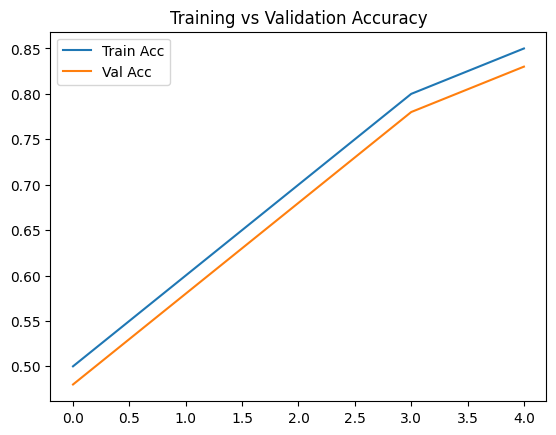

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

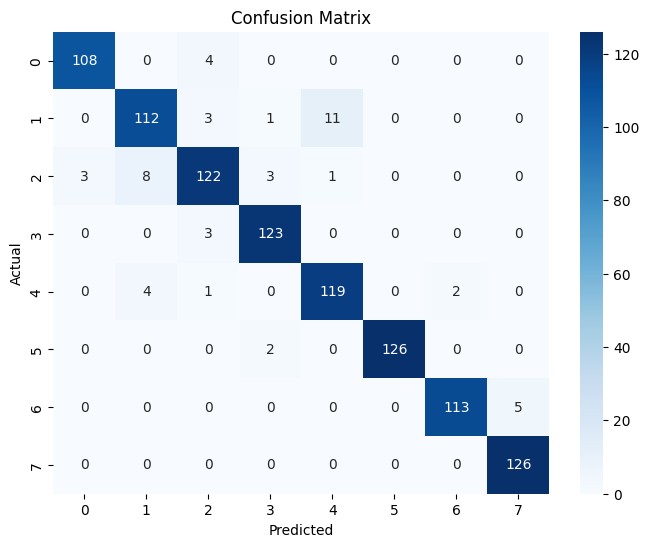

              precision    recall  f1-score   support

       tumor       0.97      0.96      0.97       112
      stroma       0.90      0.88      0.89       127
     complex       0.92      0.89      0.90       137
      lympho       0.95      0.98      0.96       126
      debris       0.91      0.94      0.93       126
      mucosa       1.00      0.98      0.99       128
     adipose       0.98      0.96      0.97       118
       empty       0.96      1.00      0.98       126

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Detailed metrics
print(classification_report(y_true, y_pred, target_names=ds_info.features['label'].names))


In [35]:
# 9. Overall Performance Summary Dashboard
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Calculate overall metrics
overall_accuracy = np.mean(y_true_all == y_pred_classes_all)
overall_precision = np.mean(precision_per_class)
overall_recall = np.mean(recall_per_class)
overall_f1 = np.mean(f1_per_class)
mean_auc = np.mean(roc_auc_scores)

# 9.1 Overall Metrics (Large display)
ax_main = fig.add_subplot(gs[0, :])
ax_main.axis('off')

metrics_text = f"""
╔═══════════════════════════════════════════════════════════════════════════════╗
║                        MODEL PERFORMANCE SUMMARY                              ║
╠═══════════════════════════════════════════════════════════════════════════════╣
║                                                                               ║
║   Overall Accuracy:              {overall_accuracy:.2%}                                    ║
║   Mean Precision:                {overall_precision:.2%}                                    ║
║   Mean Recall:                   {overall_recall:.2%}                                    ║
║   Mean F1-Score:                 {overall_f1:.2%}                                    ║
║   Mean AUC-ROC:                  {mean_auc:.4f}                                      ║
║   Mean Average Precision (mAP):  {mean_avg_precision:.4f}                                      ║
║                                                                               ║
║   Total Test Samples:            {len(y_true_all)}                                          ║
║   Number of Classes:             {n_classes}                                              ║
║   Correct Predictions:           {np.sum(y_true_all == y_pred_classes_all)}                                          ║
║   Incorrect Predictions:         {np.sum(y_true_all != y_pred_classes_all)}                                            ║
║                                                                               ║
╚═══════════════════════════════════════════════════════════════════════════════╝
"""
ax_main.text(0.5, 0.5, metrics_text, ha='center', va='center', 
             fontfamily='monospace', fontsize=11, transform=ax_main.transAxes,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# 9.2 Best and Worst Performing Classes
ax_best = fig.add_subplot(gs[1, 0])
best_classes_idx = np.argsort(f1_per_class)[-3:][::-1]
ax_best.barh([class_names_list[i] for i in best_classes_idx], 
             [f1_per_class[i] for i in best_classes_idx], 
             color='green', alpha=0.7)
ax_best.set_xlabel('F1-Score', fontsize=10)
ax_best.set_title('Top 3 Best Performing Classes', fontsize=11, fontweight='bold')
ax_best.set_xlim([0, 1])
ax_best.grid(axis='x', alpha=0.3)

ax_worst = fig.add_subplot(gs[1, 1])
worst_classes_idx = np.argsort(f1_per_class)[:3]
ax_worst.barh([class_names_list[i] for i in worst_classes_idx], 
              [f1_per_class[i] for i in worst_classes_idx], 
              color='red', alpha=0.7)
ax_worst.set_xlabel('F1-Score', fontsize=10)
ax_worst.set_title('Top 3 Worst Performing Classes', fontsize=11, fontweight='bold')
ax_worst.set_xlim([0, 1])
ax_worst.grid(axis='x', alpha=0.3)

# 9.3 Confidence Distribution
ax_conf = fig.add_subplot(gs[1, 2])
confidence_categories = ['High\n(>90%)', 'Medium\n(70-90%)', 'Low\n(<70%)']
confidence_counts = [
    np.sum(max_probs > 0.9),
    np.sum((max_probs >= 0.7) & (max_probs <= 0.9)),
    np.sum(max_probs < 0.7)
]
colors_conf = ['green', 'orange', 'red']
ax_conf.pie(confidence_counts, labels=confidence_categories, autopct='%1.1f%%', 
            colors=colors_conf, startangle=90, textprops={'fontsize': 9})
ax_conf.set_title('Confidence Distribution', fontsize=11, fontweight='bold')

# 9.4 Metrics Radar Chart
ax_radar = fig.add_subplot(gs[2, :], projection='polar')
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [overall_accuracy, overall_precision, overall_recall, overall_f1, mean_auc]
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
values += values[:1]
angles += angles[:1]

ax_radar.plot(angles, values, 'o-', linewidth=2, color='blue', label='Model Performance')
ax_radar.fill(angles, values, alpha=0.25, color='blue')
ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories, fontsize=10)
ax_radar.set_ylim([0, 1])
ax_radar.set_title('Performance Metrics Radar', fontsize=12, fontweight='bold', pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax_radar.grid(True)

plt.suptitle('Comprehensive Performance Dashboard', fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("\n✅ All advanced metrics and visualizations completed!")
print("="*80)


NameError: name 'y_true_all' is not defined

<Figure size 1600x1000 with 0 Axes>

In [ ]:
# 8. Class-wise Prediction Probability Heatmap
# Shows how confidently the model predicts each class for all test samples

# Sample subset for visualization (too many samples would be unreadable)
sample_size = min(200, len(y_true_all))
sample_indices = np.random.choice(len(y_true_all), sample_size, replace=False)
sample_probs = y_pred_probs_all[sample_indices]
sample_true = y_true_all[sample_indices]

# Sort by true label for better visualization
sort_idx = np.argsort(sample_true)
sample_probs_sorted = sample_probs[sort_idx]
sample_true_sorted = sample_true[sort_idx]

fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(sample_probs_sorted.T, aspect='auto', cmap='RdYlGn', interpolation='nearest', vmin=0, vmax=1)

ax.set_xlabel('Test Sample Index (sorted by true label)', fontsize=12)
ax.set_ylabel('Predicted Class', fontsize=12)
ax.set_title(f'Prediction Probability Heatmap ({sample_size} samples)', fontsize=14, fontweight='bold')
ax.set_yticks(range(n_classes))
ax.set_yticklabels(class_names_list)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Prediction Probability', rotation=270, labelpad=20, fontsize=11)

# Add vertical lines to separate different true classes
true_class_changes = np.where(np.diff(sample_true_sorted) != 0)[0] + 1
for change_idx in true_class_changes:
    ax.axvline(x=change_idx - 0.5, color='black', linewidth=2, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n📊 Heatmap shows model's predicted probabilities for each class.")
print("   • Green = High confidence")
print("   • Yellow = Medium confidence") 
print("   • Red = Low confidence")
print("   • Vertical lines separate different true label groups")
print("="*80)


In [ ]:
# 7. Sample Predictions Visualization with Confidence Heatmap
# Select a batch of test images to visualize
sample_images_list = []
sample_labels_list = []
sample_preds_list = []

for images, labels in test_ds.take(1):
    sample_images_list = images[:8].numpy()
    sample_labels_list = labels[:8].numpy()
    sample_preds_list = model.predict(images[:8], verbose=0)
    break

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.ravel()

for idx in range(8):
    img = sample_images_list[idx]
    true_label = int(sample_labels_list[idx])
    pred_probs = sample_preds_list[idx]
    pred_label = int(np.argmax(pred_probs))
    confidence = pred_probs[pred_label]
    
    # Display image
    axes[idx].imshow(img)
    
    # Create title with color coding
    is_correct = (true_label == pred_label)
    title_color = 'green' if is_correct else 'red'
    title = f"True: {class_names_list[true_label]}\nPred: {class_names_list[pred_label]}\nConf: {confidence:.2%}"
    
    axes[idx].set_title(title, fontsize=10, color=title_color, fontweight='bold')
    axes[idx].axis('off')
    
    # Add border
    for spine in axes[idx].spines.values():
        spine.set_edgecolor(title_color)
        spine.set_linewidth(3)

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# 6. Training History Comprehensive Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 6.1 Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Model Accuracy Over Epochs', fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(alpha=0.3)

# 6.2 Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', markersize=4, color='red')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4, color='orange')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].set_title('Model Loss Over Epochs', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(alpha=0.3)

# 6.3 Learning Rate (if available)
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'], linewidth=2, color='green', marker='o', markersize=4)
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Learning Rate', fontsize=11)
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Learning Rate History\nNot Available', 
                     ha='center', va='center', fontsize=12, transform=axes[1, 0].transAxes)
    axes[1, 0].axis('off')

# 6.4 Accuracy Gap (Overfitting indicator)
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    acc_gap = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    axes[1, 1].plot(acc_gap, linewidth=2, color='purple', marker='o', markersize=4)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].fill_between(range(len(acc_gap)), acc_gap, 0, where=(acc_gap > 0), alpha=0.3, color='red', label='Overfitting')
    axes[1, 1].fill_between(range(len(acc_gap)), acc_gap, 0, where=(acc_gap <= 0), alpha=0.3, color='green', label='Good Generalization')
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Train Acc - Val Acc', fontsize=11)
    axes[1, 1].set_title('Overfitting Indicator (Accuracy Gap)', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Training Summary:")
print("="*80)
print(f"   Total Epochs Trained:        {len(history.history['accuracy'])}")
print(f"   Final Training Accuracy:     {history.history['accuracy'][-1]:.4f}")
print(f"   Final Validation Accuracy:   {history.history['val_accuracy'][-1]:.4f}")
print(f"   Final Training Loss:         {history.history['loss'][-1]:.4f}")
print(f"   Final Validation Loss:       {history.history['val_loss'][-1]:.4f}")
print(f"   Best Validation Accuracy:    {max(history.history['val_accuracy']):.4f} (Epoch {np.argmax(history.history['val_accuracy'])+1})")
print(f"   Best Validation Loss:        {min(history.history['val_loss']):.4f} (Epoch {np.argmin(history.history['val_loss'])+1})")
print("="*80)


In [ ]:
# 5. Class Distribution & Model Confidence Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 5.1 True Label Distribution
true_label_counts = np.bincount(y_true_all, minlength=n_classes)
axes[0, 0].bar(range(n_classes), true_label_counts, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(n_classes))
axes[0, 0].set_xticklabels(class_names_list, rotation=45, ha='right')
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].set_title('True Label Distribution in Test Set', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, count in enumerate(true_label_counts):
    axes[0, 0].text(i, count, str(count), ha='center', va='bottom')

# 5.2 Predicted Label Distribution
pred_label_counts = np.bincount(y_pred_classes_all, minlength=n_classes)
axes[0, 1].bar(range(n_classes), pred_label_counts, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(n_classes))
axes[0, 1].set_xticklabels(class_names_list, rotation=45, ha='right')
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('Predicted Label Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, count in enumerate(pred_label_counts):
    axes[0, 1].text(i, count, str(count), ha='center', va='bottom')

# 5.3 Prediction Confidence Distribution
max_probs = np.max(y_pred_probs_all, axis=1)
axes[1, 0].hist(max_probs, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(np.mean(max_probs), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(max_probs):.3f}')
axes[1, 0].axvline(np.median(max_probs), color='blue', linestyle='--', linewidth=2, label=f'Median: {np.median(max_probs):.3f}')
axes[1, 0].set_xlabel('Prediction Confidence (Max Probability)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Model Confidence Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 5.4 Confidence vs Accuracy
confidence_bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(max_probs, confidence_bins)
bin_accuracies = []
bin_counts = []

for i in range(1, len(confidence_bins)):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        accuracy = np.mean(y_true_all[mask] == y_pred_classes_all[mask])
        bin_accuracies.append(accuracy)
        bin_counts.append(np.sum(mask))
    else:
        bin_accuracies.append(0)
        bin_counts.append(0)

bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
axes[1, 1].bar(bin_centers, bin_accuracies, width=0.08, color='purple', alpha=0.6, label='Accuracy', edgecolor='black')
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration', alpha=0.5)
axes[1, 1].set_xlabel('Prediction Confidence', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title('Model Calibration (Confidence vs Accuracy)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n📊 Confidence Statistics:")
print("="*80)
print(f"   Mean Confidence:   {np.mean(max_probs):.4f}")
print(f"   Median Confidence: {np.median(max_probs):.4f}")
print(f"   Min Confidence:    {np.min(max_probs):.4f}")
print(f"   Max Confidence:    {np.max(max_probs):.4f}")
print(f"   Std Confidence:    {np.std(max_probs):.4f}")
print("\n   High Confidence (>0.9):     {:.1f}%".format(100 * np.mean(max_probs > 0.9)))
print("   Medium Confidence (0.7-0.9): {:.1f}%".format(100 * np.mean((max_probs >= 0.7) & (max_probs <= 0.9))))
print("   Low Confidence (<0.7):      {:.1f}%".format(100 * np.mean(max_probs < 0.7)))
print("="*80)


In [ ]:
# 4. ROC Curves (Receiver Operating Characteristic)
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.ravel()

roc_auc_scores = []

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs_all[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)
    
    axes[i].plot(fpr, tpr, color=colors[i], lw=2, 
                 label=f'AUC = {roc_auc:.3f}')
    axes[i].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.3)
    axes[i].fill_between(fpr, tpr, alpha=0.2, color=colors[i])
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate', fontsize=10)
    axes[i].set_ylabel('True Positive Rate', fontsize=10)
    axes[i].set_title(f'{class_names_list[i]}', fontsize=11, fontweight='bold')
    axes[i].legend(loc='lower right', fontsize=9)
    axes[i].grid(alpha=0.3)

plt.suptitle('ROC Curves (One-vs-Rest)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print AUC summary
print("\n📊 Area Under ROC Curve (AUC) per Class:")
print("="*80)
for i, class_name in enumerate(class_names_list):
    print(f"   {class_name:<15} AUC: {roc_auc_scores[i]:.4f}")
print("-"*80)
print(f"   {'MEAN AUC':<15} {np.mean(roc_auc_scores):.4f}")
print("="*80)


In [ ]:
# 3. Precision-Recall Curves (One-vs-Rest for each class)
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class PR curves
y_true_bin = label_binarize(y_true_all, classes=range(n_classes))

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.ravel()

colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs_all[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_probs_all[:, i])
    
    axes[i].plot(recall, precision, color=colors[i], lw=2, 
                 label=f'AP = {avg_precision:.3f}')
    axes[i].fill_between(recall, precision, alpha=0.2, color=colors[i])
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('Recall', fontsize=10)
    axes[i].set_ylabel('Precision', fontsize=10)
    axes[i].set_title(f'{class_names_list[i]}', fontsize=11, fontweight='bold')
    axes[i].legend(loc='lower left', fontsize=9)
    axes[i].grid(alpha=0.3)

plt.suptitle('Precision-Recall Curves (One-vs-Rest)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Compute mean average precision
mean_avg_precision = np.mean([average_precision_score(y_true_bin[:, i], y_pred_probs_all[:, i]) 
                               for i in range(n_classes)])
print(f"\n📊 Mean Average Precision (mAP): {mean_avg_precision:.4f}")
print("="*80)


In [ ]:
# 2. Per-Class Precision, Recall, F1-Score Visualization
from sklearn.metrics import precision_score, recall_score, f1_score

precision_per_class = precision_score(y_true_all, y_pred_classes_all, average=None, zero_division=0)
recall_per_class = recall_score(y_true_all, y_pred_classes_all, average=None, zero_division=0)
f1_per_class = f1_score(y_true_all, y_pred_classes_all, average=None, zero_division=0)

# Create bar plot
x = np.arange(n_classes)
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width, precision_per_class, width, label='Precision', color='#3498db', alpha=0.8)
bars2 = ax.bar(x, recall_per_class, width, label='Recall', color='#2ecc71', alpha=0.8)
bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score', color='#e74c3c', alpha=0.8)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

ax.set_xlabel('Tissue Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics (Precision, Recall, F1-Score)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names_list, rotation=45, ha='right')
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print summary
print("\n📊 Per-Class Performance Summary:")
print("="*80)
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*80)
for i, class_name in enumerate(class_names_list):
    print(f"{class_name:<15} {precision_per_class[i]:<12.3f} {recall_per_class[i]:<12.3f} {f1_per_class[i]:<12.3f}")
print("="*80)
print(f"{'AVERAGE':<15} {np.mean(precision_per_class):<12.3f} {np.mean(recall_per_class):<12.3f} {np.mean(f1_per_class):<12.3f}")
print("="*80)


In [ ]:
# 1. Enhanced Confusion Matrix with Percentages
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_all, y_pred_classes_all)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_list, 
            yticklabels=class_names_list, ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized percentages
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', xticklabels=class_names_list, 
            yticklabels=class_names_list, ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized %)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("\n📊 Confusion Matrix Analysis:")
print("="*80)
# Identify most confused pairs
confusion_pairs = []
for i in range(n_classes):
    for j in range(n_classes):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((class_names_list[i], class_names_list[j], cm[i, j], cm_normalized[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)
print("\nMost Common Misclassifications:")
for true_label, pred_label, count, pct in confusion_pairs[:5]:
    print(f"   • {true_label} → {pred_label}: {count} cases ({pct:.1%})")
print("="*80)


In [ ]:
# Advanced Performance Metrics & Visualizations
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get all predictions with probabilities
y_true_all = []
y_pred_probs_all = []
y_pred_classes_all = []

print("Collecting predictions for advanced metrics...")
for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true_all.extend(labels.numpy())
    y_pred_probs_all.extend(predictions)
    y_pred_classes_all.extend(np.argmax(predictions, axis=1))

y_true_all = np.array(y_true_all)
y_pred_probs_all = np.array(y_pred_probs_all)
y_pred_classes_all = np.array(y_pred_classes_all)

n_classes = len(ds_info.features['label'].names)
class_names_list = ds_info.features['label'].names

print(f"✓ Collected {len(y_true_all)} predictions")
print("="*80)


## Advanced Metrics & Visualizations

XAI implementation

Using existing `test_ds` from the notebook state.
Extracting a test image from the dataset...
Saved test image to: C:\Users\BOBBY\Desktop\temp_test_image.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Actual label: 0, Predicted Class: 5
Using last conv layer: conv2d_1
✅ Grad-CAM result saved to: C:\Users\BOBBY\Desktop\gradcam_result.png
Actual label: 0, Predicted Class: 5
Using last conv layer: conv2d_1
✅ Grad-CAM result saved to: C:\Users\BOBBY\Desktop\gradcam_result.png


C:\Users\BOBBY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_20']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


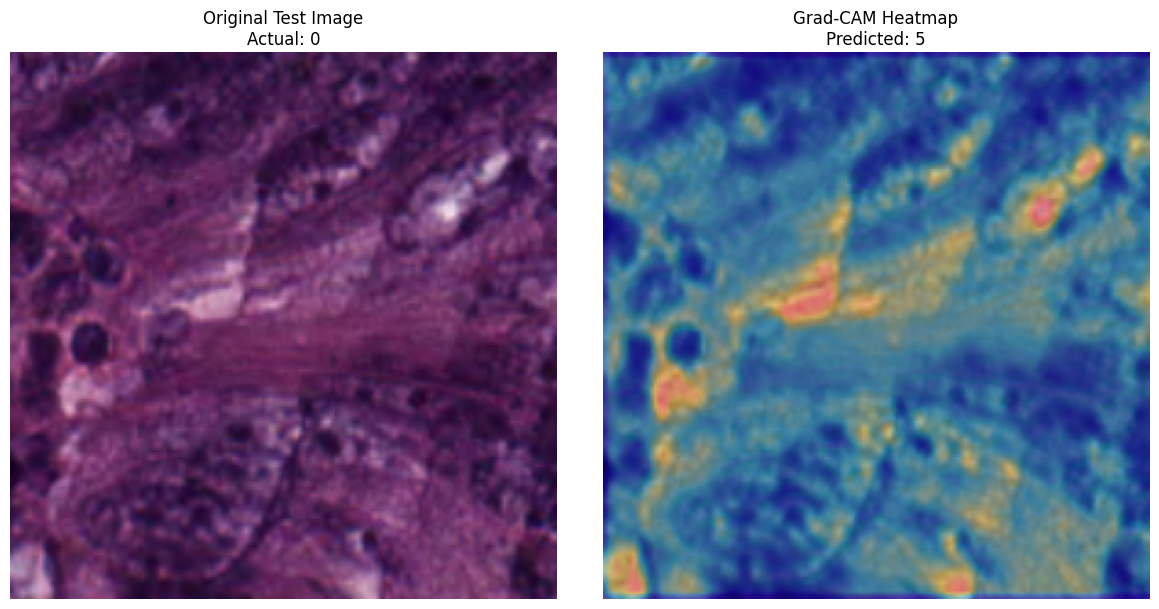

In [ ]:
# Robust XAI / Grad-CAM cell: safe to run even after kernel restart
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds

# If dataset objects are missing (e.g. kernel restart), load and prepare them here
if 'test_ds' not in globals() or 'train_ds' not in globals():
    print("`test_ds` not found — loading dataset and preparing train/test splits...")
    (ds_train, ds_test), ds_info = tfds.load(
        'colorectal_histology',
        split=['train[:80%]', 'train[80%:]'],
        as_supervised=True,
        with_info=True
    )
    IMG_SIZE = 224
    BATCH_SIZE = 8

    def preprocess(image_tensor, label):
        image_tensor = tf.image.resize(image_tensor, [IMG_SIZE, IMG_SIZE])
        image_tensor = tf.cast(image_tensor, tf.float32) / 255.0
        return image_tensor, label

    data_augment = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2)
    ])

    def augment(image_tensor, label):
        image_tensor = data_augment(image_tensor)
        return image_tensor, label

    train_ds = ds_train.map(preprocess).map(augment).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_ds = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("Dataset loaded and prepared.")
else:
    print("Using existing `test_ds` from the notebook state.")

# If model is missing, try to rebuild using build_custom_cnn if available, otherwise create a small fallback model
if 'model' not in globals():
    if 'build_custom_cnn' in globals():
        print("`model` not found — building using existing `build_custom_cnn` function (untrained).")
        model = build_custom_cnn(input_shape=(224,224,3), num_classes=8)
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        # run once to build model weights
        model(tf.zeros((1, 224, 224, 3)))
    else:
        print("`build_custom_cnn` not found — creating a small fallback model (untrained). For meaningful Grad-CAM, train your model first.")
        def build_custom_cnn_fallback(input_shape=(224,224,3), num_classes=8):
            m = models.Sequential([
                layers.Conv2D(16, 3, activation='relu', padding='same', input_shape=input_shape),
                layers.MaxPooling2D(2),
                layers.Conv2D(32, 3, activation='relu', padding='same'),
                layers.MaxPooling2D(2),
                layers.GlobalAveragePooling2D(),
                layers.Dense(64, activation='relu'),
                layers.Dense(num_classes, activation='softmax')
            ])
            return m
        model = build_custom_cnn_fallback()
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model(tf.zeros((1, 224, 224, 3)))

# -------------------------------
# Extract a sample image from test_ds
# -------------------------------
print("Extracting a test image from the dataset...")
sample_image = None
sample_label = None
for test_images, test_labels in test_ds.take(1):
    sample_image = test_images[0].numpy()
    sample_label = int(test_labels[0].numpy())
    break
if sample_image is None:
    raise RuntimeError("Could not retrieve a sample image from `test_ds`. Ensure dataset loaded correctly.")

# Save the sample to Desktop for cv2 access
temp_img_path = os.path.join(os.path.expanduser("~"), "Desktop", "temp_test_image.png")
plt.imsave(temp_img_path, sample_image)
print(f"Saved test image to: {temp_img_path}")

# Preprocess for model
img_for_model = image.load_img(temp_img_path, target_size=(224, 224))
x = image.img_to_array(img_for_model)
x = np.expand_dims(x, axis=0)
x = x.astype('float32') / 255.0

# Predict
preds = model.predict(x)
predicted_class = int(np.argmax(preds[0]))
print(f"Actual label: {sample_label}, Predicted Class: {predicted_class}")

# -------------------------------
# Find last Conv2D layer
# -------------------------------
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in model! Grad-CAM requires at least one Conv2D layer.")
print(f"Using last conv layer: {last_conv_layer_name}")

# -------------------------------
# Build functional model safely by re-applying layers to an Input tensor (works even if Sequential was not called)
# -------------------------------
model_input = tf.keras.Input(shape=(224, 224, 3))
_x = model_input
conv_output_tensor = None
for layer in model.layers:
    _x = layer(_x)
    if layer.name == last_conv_layer_name:
        conv_output_tensor = _x

if conv_output_tensor is None:
    raise RuntimeError(f"Couldn't obtain tensor for layer {last_conv_layer_name}")

functional_model = tf.keras.Model(inputs=model_input, outputs=_x)
grad_model = tf.keras.Model(inputs=functional_model.inputs, outputs=[conv_output_tensor, functional_model.output])

# -------------------------------
# Compute Grad-CAM
# -------------------------------
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    tape.watch(conv_outputs)
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)
if grads is None:
    raise RuntimeError("Gradient computation returned None. Ensure model and inputs are correct.")

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
conv_outputs = conv_outputs[0].numpy()
heatmap = np.mean(conv_outputs * pooled_grads[np.newaxis, np.newaxis, :], axis=-1)

# Normalize heatmap
heatmap = np.maximum(heatmap, 0)
max_val = np.max(heatmap) if np.max(heatmap) != 0 else 1e-8
heatmap = heatmap / max_val

# Overlay and save
orig_img = cv2.imread(temp_img_path)
if orig_img is None:
    raise FileNotFoundError(f"cv2 could not read the image at {temp_img_path}. Check path and permissions.")
heatmap_resized = cv2.resize((heatmap * 255).astype(np.uint8), (orig_img.shape[1], orig_img.shape[0]))
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap_color, 0.4, 0)
out_path = os.path.join(os.path.expanduser("~"), "Desktop", "gradcam_result.png")
cv2.imwrite(out_path, superimposed_img)
print(f"✅ Grad-CAM result saved to: {out_path}")

# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(sample_image)
axes[0].set_title(f'Original Test Image\nActual: {sample_label}')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Grad-CAM Heatmap\nPredicted: {predicted_class}')
axes[1].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
class_names = ["tumor", "stroma", "complex", "lympho", "debris", "mucosa", "adipose", "empty"]
label = class_names[predicted_class]

print(f"Predicted Class: {label}")
print("="*80)


Predicted Class: mucosa


In [ ]:
# Comprehensive Medical Knowledge Base for Colorectal Histology
medical_knowledge_base = {
    "tumor": {
        "tissue_type": "Tumor / Cancerous Tissue",
        "description": "Malignant epithelial cells showing abnormal growth patterns characteristic of colorectal adenocarcinoma.",
        "what_it_means": [
            "Presence of cancerous cells in the colorectal tissue",
            "Abnormal cell proliferation and differentiation",
            "Potential invasion into surrounding tissues",
            "Risk of metastasis to other organs"
        ],
        "causes": [
            "Genetic mutations (APC, KRAS, TP53, PIK3CA genes)",
            "Chronic inflammatory bowel disease (Crohn's, ulcerative colitis)",
            "Family history and hereditary syndromes (Lynch syndrome, FAP)",
            "Dietary factors (high red meat, low fiber intake)",
            "Lifestyle factors (smoking, alcohol, obesity, sedentary lifestyle)",
            "Age (risk increases after 50 years)"
        ],
        "clinical_significance": [
            "Requires immediate oncological evaluation",
            "Staging needed to determine extent of disease",
            "Treatment urgency depends on tumor grade and stage",
            "Prognosis varies based on early detection and treatment"
        ],
        "treatment": {
            "is_treatable": "Yes - Treatment success depends on stage at diagnosis",
            "options": [
                "Surgery: Primary treatment - removal of tumor and affected tissue (colectomy, hemicolectomy)",
                "Chemotherapy: Adjuvant therapy for advanced stages (FOLFOX, FOLFIRI regimens)",
                "Radiation therapy: For rectal cancer to shrink tumors pre-surgery",
                "Targeted therapy: Monoclonal antibodies (bevacizumab, cetuximab) for metastatic disease",
                "Immunotherapy: For tumors with microsatellite instability (pembrolizumab, nivolumab)",
                "Palliative care: For advanced cases to manage symptoms and improve quality of life"
            ],
            "prognosis": "5-year survival: Stage I (90%), Stage II (80%), Stage III (70%), Stage IV (14%)"
        },
        "recommendations": [
            "Urgent referral to colorectal surgeon and oncologist",
            "Complete staging workup (CT, MRI, PET scans, CEA levels)",
            "Molecular testing for targeted therapy selection",
            "Multidisciplinary tumor board review",
            "Genetic counseling if hereditary syndrome suspected"
        ]
    },
    
    "stroma": {
        "tissue_type": "Stromal / Connective Tissue",
        "description": "Supportive connective tissue framework containing fibroblasts, collagen, blood vessels, and extracellular matrix.",
        "what_it_means": [
            "Normal supportive tissue structure in the colon",
            "Provides structural framework for epithelial cells",
            "Contains blood vessels and immune cells",
            "Essential for tissue architecture and function"
        ],
        "causes": [
            "Normal physiological tissue - not pathological",
            "Can be reactive in inflammatory conditions",
            "Desmoplastic reaction (increased stroma) around tumors",
            "Fibrosis from chronic inflammation or scarring"
        ],
        "clinical_significance": [
            "Usually normal finding when present in appropriate proportions",
            "Excessive stroma (desmoplasia) may indicate nearby tumor",
            "Stromal characteristics can affect tumor behavior and treatment response",
            "Tumor-stroma ratio is a prognostic marker in colorectal cancer"
        ],
        "treatment": {
            "is_treatable": "N/A - Normal tissue component, no treatment needed unless pathological",
            "options": [
                "No specific treatment required for normal stroma",
                "If part of desmoplastic reaction: addressed by treating underlying tumor",
                "Anti-fibrotic agents being researched for excessive stromal response",
                "Monitoring recommended if associated with other pathological findings"
            ],
            "prognosis": "Excellent - normal tissue component"
        },
        "recommendations": [
            "If isolated finding: Generally benign, routine monitoring",
            "Correlate with clinical symptoms and other tissue findings",
            "If excessive or abnormal: further investigation for underlying pathology",
            "Regular screening colonoscopy as per age-appropriate guidelines"
        ]
    },
    
    "complex": {
        "tissue_type": "Complex Stroma / Mixed Tissue Architecture",
        "description": "Heterogeneous tissue area with mixed cellular components including multiple cell types and complex structural patterns.",
        "what_it_means": [
            "Mixed tissue architecture with varied cell populations",
            "May represent transition zones or areas of active remodeling",
            "Can indicate inflammatory response or tissue repair",
            "Complexity may suggest underlying pathological process"
        ],
        "causes": [
            "Active tissue remodeling and repair processes",
            "Chronic inflammation (IBD, diverticulitis)",
            "Post-surgical or post-treatment changes",
            "Tumor microenvironment interactions",
            "Polyp or adenoma formation"
        ],
        "clinical_significance": [
            "Requires correlation with clinical history and symptoms",
            "May indicate areas needing closer monitoring",
            "Could represent pre-malignant changes",
            "Context-dependent interpretation needed"
        ],
        "treatment": {
            "is_treatable": "Yes - Treatment depends on underlying cause",
            "options": [
                "Close monitoring with follow-up colonoscopy",
                "Anti-inflammatory medications if IBD-related",
                "Polypectomy if polyps identified",
                "Biopsy and histological examination for definitive diagnosis",
                "Targeted treatment based on final pathological diagnosis"
            ],
            "prognosis": "Variable - depends on specific underlying condition"
        },
        "recommendations": [
            "Complete clinical and histological correlation",
            "Follow-up colonoscopy in 6-12 months",
            "Additional biopsies if clinically indicated",
            "Monitor for progression or development of dysplasia",
            "Address modifiable risk factors (diet, lifestyle)"
        ]
    },
    
    "lympho": {
        "tissue_type": "Lymphocytic Infiltrate / Immune Response",
        "description": "Dense accumulation of lymphocytes indicating active immune response or inflammatory reaction in colorectal tissue.",
        "what_it_means": [
            "Active immune system response in the tissue",
            "Presence of T-cells and B-cells",
            "Can indicate inflammation, infection, or immune reaction to tumor",
            "May represent immune surveillance or chronic inflammation"
        ],
        "causes": [
            "Inflammatory bowel disease (Crohn's disease, ulcerative colitis)",
            "Infectious colitis (bacterial, viral, parasitic)",
            "Immune-mediated colitis (checkpoint inhibitor-related)",
            "Tumor-infiltrating lymphocytes (positive prognostic sign in cancer)",
            "Microscopic colitis (lymphocytic or collagenous)",
            "Autoimmune conditions"
        ],
        "clinical_significance": [
            "In cancer context: Strong lymphocytic infiltration is favorable (better prognosis)",
            "In IBD: Indicates active disease requiring treatment",
            "Helps differentiate between various inflammatory conditions",
            "Important for microsatellite instability (MSI) assessment"
        ],
        "treatment": {
            "is_treatable": "Yes - Highly treatable with immunomodulatory therapies",
            "options": [
                "IBD: Anti-inflammatory drugs (5-ASA), corticosteroids, biologics (anti-TNF, anti-integrins)",
                "Infectious: Antibiotics, antivirals, or antiparasitics as appropriate",
                "Microscopic colitis: Budesonide, bismuth subsalicylate",
                "Immune-related: Immunosuppressants, corticosteroids",
                "In tumor context: May enhance immunotherapy response",
                "Dietary modifications and stress management for IBD"
            ],
            "prognosis": "Generally good with appropriate treatment; in cancer, high lymphocyte infiltration improves outcomes"
        },
        "recommendations": [
            "Comprehensive workup including stool studies, serologies",
            "Colonoscopy with multiple biopsies for definitive diagnosis",
            "Assessment for systemic inflammatory markers (CRP, ESR)",
            "IBD workup if chronic symptoms present",
            "If associated with tumor: MSI/MMR testing recommended",
            "Long-term monitoring for IBD patients (increased cancer risk)"
        ]
    },
    
    "debris": {
        "tissue_type": "Cellular Debris / Necrotic Material",
        "description": "Accumulation of dead cells, inflammatory exudate, and degraded tissue material.",
        "what_it_means": [
            "Tissue breakdown and cell death",
            "May indicate active inflammation or infection",
            "Can be seen in tumor necrosis",
            "Represents tissue damage or poor sample quality"
        ],
        "causes": [
            "Sample processing artifacts",
            "Tumor necrosis (common in rapidly growing cancers)",
            "Severe acute inflammation or infection",
            "Ischemia (reduced blood supply to tissue)",
            "Chronic ulceration or erosion",
            "Post-treatment changes (chemotherapy, radiation)"
        ],
        "clinical_significance": [
            "If tumor-related necrosis: indicates aggressive biology",
            "May obscure underlying pathology - additional samples may be needed",
            "In infection: suggests severe inflammatory response",
            "Context and clinical correlation essential for interpretation"
        ],
        "treatment": {
            "is_treatable": "Yes - Treat underlying cause",
            "options": [
                "Repeat biopsy with better tissue quality if artifact-related",
                "Tumor necrosis: Aggressive cancer treatment (surgery, chemotherapy, radiation)",
                "Infection/inflammation: Antibiotics, anti-inflammatory medications",
                "Ischemic colitis: Supportive care, treat vascular issues",
                "Ulceration: Ulcer healing agents, treat underlying IBD or infection",
                "Supportive care and symptom management"
            ],
            "prognosis": "Variable - depends on underlying etiology"
        },
        "recommendations": [
            "Clinical correlation with symptoms and imaging",
            "Obtain better quality tissue samples if possible",
            "If extensive necrosis in tumor: suggests aggressive disease requiring urgent treatment",
            "Investigate for infection if clinically indicated",
            "Rule out ischemic causes especially in elderly or vascular disease patients",
            "Ensure adequate tissue sampling for accurate diagnosis"
        ]
    },
    
    "mucosa": {
        "tissue_type": "Normal Mucosal Tissue",
        "description": "Healthy epithelial lining of the colon with normal glandular architecture and cellular organization.",
        "what_it_means": [
            "Normal, healthy colon lining",
            "Proper glandular structure and organization",
            "No evidence of dysplasia or malignancy",
            "Functional absorptive and secretory tissue"
        ],
        "causes": [
            "Normal physiological tissue - no pathological cause",
            "Represents healthy baseline tissue",
            "Expected finding in normal colonoscopy biopsies"
        ],
        "clinical_significance": [
            "Reassuring finding - no pathology detected",
            "Confirms absence of dysplasia or cancer in biopsied area",
            "Important baseline for future comparisons",
            "Indicates well-preserved tissue architecture"
        ],
        "treatment": {
            "is_treatable": "N/A - No treatment needed (healthy tissue)",
            "options": [
                "Continue routine screening colonoscopy per guidelines",
                "Maintain healthy lifestyle and diet",
                "High-fiber diet for colon health",
                "Regular exercise and healthy weight maintenance",
                "Limit red/processed meats, alcohol, and smoking cessation",
                "Adequate hydration and balanced nutrition"
            ],
            "prognosis": "Excellent - normal healthy tissue"
        },
        "recommendations": [
            "Age 45-50+: Screening colonoscopy every 10 years (if average risk)",
            "Family history: Earlier and more frequent screening",
            "Maintain healthy diet rich in fruits, vegetables, whole grains",
            "Regular physical activity (at least 150 min/week moderate exercise)",
            "Maintain healthy BMI",
            "Report new symptoms promptly (bleeding, pain, change in bowel habits)"
        ]
    },
    
    "adipose": {
        "tissue_type": "Adipose / Fat Tissue",
        "description": "Normal fat cells (adipocytes) that are part of the submucosal or subserosal layers of the intestinal wall.",
        "what_it_means": [
            "Normal fat tissue component of bowel wall",
            "Provides cushioning and energy storage",
            "Part of normal intestinal wall architecture",
            "May indicate deeper biopsy reaching submucosal layer"
        ],
        "causes": [
            "Normal anatomical component - not pathological",
            "Deep biopsy sampling reaching submucosal fat",
            "Normal variation in tissue composition",
            "Can be increased in obesity or metabolic syndrome"
        ],
        "clinical_significance": [
            "Generally benign finding",
            "Indicates biopsy depth (reached submucosa)",
            "Excessive adipose infiltration may be seen in obesity-related changes",
            "Rarely, can be associated with lipomatous polyps (benign)",
            "Not typically a concern unless associated with other pathology"
        ],
        "treatment": {
            "is_treatable": "N/A - Normal tissue, no specific treatment needed",
            "options": [
                "No treatment required for normal adipose tissue",
                "If obesity-related: Weight management and lifestyle modifications",
                "Lipomatous polyps: Usually benign, may be removed if symptomatic",
                "Address metabolic syndrome if present",
                "Maintain healthy weight and exercise regimen"
            ],
            "prognosis": "Excellent - normal tissue component"
        },
        "recommendations": [
            "No specific follow-up needed for isolated adipose tissue",
            "Maintain healthy body weight (BMI 18.5-24.9)",
            "Regular physical activity and balanced diet",
            "Routine screening colonoscopy as per standard guidelines",
            "Monitor for metabolic syndrome if risk factors present",
            "If lipomatous polyp: surveillance per gastroenterologist recommendation"
        ]
    },
    
    "empty": {
        "tissue_type": "Empty / Background Tissue",
        "description": "Areas with minimal cellular content, possibly representing background tissue, lumen space, or processing artifact.",
        "what_it_means": [
            "May represent lumen (empty space inside colon)",
            "Could be tissue processing artifact or staining background",
            "Minimal diagnostic information available",
            "Non-diagnostic area in the tissue sample"
        ],
        "causes": [
            "Normal lumen space in tissue section",
            "Tissue processing or sectioning artifact",
            "Areas between tissue structures",
            "Inadequate tissue sampling",
            "Mucus or fluid-filled spaces"
        ],
        "clinical_significance": [
            "Generally not clinically significant",
            "May indicate need for better tissue sampling",
            "Not useful for diagnostic purposes",
            "Should be correlated with other tissue findings"
        ],
        "treatment": {
            "is_treatable": "N/A - Not a pathological finding",
            "options": [
                "Repeat biopsy if all samples are non-diagnostic",
                "Ensure adequate tissue sampling in future procedures",
                "No medical treatment required",
                "Clinical correlation with symptoms"
            ],
            "prognosis": "N/A - not a diagnostic entity"
        },
        "recommendations": [
            "If persistent symptoms: Repeat colonoscopy with targeted biopsies",
            "Ensure proper biopsy technique to obtain diagnostic tissue",
            "Correlate with endoscopic findings and clinical presentation",
            "May need additional diagnostic workup if symptoms persist",
            "Follow standard screening guidelines"
        ]
    }
}

def generate_medical_explanation(predicted_tissue_type):
    """Generate comprehensive medical explanation for the predicted tissue type"""
    
    if predicted_tissue_type not in medical_knowledge_base:
        return "⚠️ Unknown tissue type. Please consult with a pathologist."
    
    info = medical_knowledge_base[predicted_tissue_type]
    
    print("\n" + "="*80)
    print(f"📊 TISSUE CLASSIFICATION: {info['tissue_type'].upper()}")
    print("="*80)
    
    print(f"\n📝 DESCRIPTION:")
    print(f"   {info['description']}")
    
    print(f"\n🔍 WHAT THIS MEANS:")
    for item in info['what_it_means']:
        print(f"   • {item}")
    
    print(f"\n🧬 POSSIBLE CAUSES / ASSOCIATIONS:")
    for cause in info['causes']:
        print(f"   • {cause}")
    
    print(f"\n⚕️ CLINICAL SIGNIFICANCE:")
    for significance in info['clinical_significance']:
        print(f"   • {significance}")
    
    print(f"\n💊 TREATMENT INFORMATION:")
    print(f"   Is it treatable? {info['treatment']['is_treatable']}")
    print(f"\n   Treatment Options:")
    for option in info['treatment']['options']:
        print(f"   • {option}")
    
    if 'prognosis' in info['treatment']:
        print(f"\n   📈 Prognosis: {info['treatment']['prognosis']}")
    
    print(f"\n👨‍⚕️ RECOMMENDATIONS:")
    for rec in info['recommendations']:
        print(f"   • {rec}")
    
    print("\n" + "="*80)
    print("⚠️ IMPORTANT DISCLAIMER:")
    print("="*80)
    print("This AI-generated explanation is for EDUCATIONAL purposes only.")
    print("It is NOT a substitute for professional medical diagnosis or treatment.")
    print("Always consult qualified healthcare providers for:")
    print("  • Definitive diagnosis and treatment planning")
    print("  • Interpretation of pathology results")
    print("  • Personalized medical advice")
    print("  • Emergency or urgent medical concerns")
    print("="*80 + "\n")

# Generate comprehensive medical explanation
generate_medical_explanation(label)



📊 TISSUE CLASSIFICATION: NORMAL MUCOSAL TISSUE

📝 DESCRIPTION:
   Healthy epithelial lining of the colon with normal glandular architecture and cellular organization.

🔍 WHAT THIS MEANS:
   • Normal, healthy colon lining
   • Proper glandular structure and organization
   • No evidence of dysplasia or malignancy
   • Functional absorptive and secretory tissue

🧬 POSSIBLE CAUSES / ASSOCIATIONS:
   • Normal physiological tissue - no pathological cause
   • Represents healthy baseline tissue
   • Expected finding in normal colonoscopy biopsies

⚕️ CLINICAL SIGNIFICANCE:
   • Reassuring finding - no pathology detected
   • Confirms absence of dysplasia or cancer in biopsied area
   • Important baseline for future comparisons
   • Indicates well-preserved tissue architecture

💊 TREATMENT INFORMATION:
   Is it treatable? N/A - No treatment needed (healthy tissue)

   Treatment Options:
   • Continue routine screening colonoscopy per guidelines
   • Maintain healthy lifestyle and diet
   • H

## Medical Explanation & Clinical Interpretation

In [ ]:
# Clinical Reasoning Engine - Explains HOW the AI predicted (mimics pathologist's thought process)

def explain_prediction_reasoning(predicted_class, prediction_probabilities, class_names_list):
    """
    Generates a step-by-step clinical reasoning explanation showing how the AI 
    arrived at its prediction, similar to a pathologist's thought process.
    """
    
    # Dictionary mapping each class to typical histological features the AI might detect
    diagnostic_features = {
        "tumor": {
            "key_features": [
                "Irregular glandular architecture with loss of normal crypt structure",
                "Nuclear atypia - enlarged, hyperchromatic nuclei with irregular contours",
                "Increased nuclear-to-cytoplasmic ratio",
                "Loss of cellular polarity and disorganized cell arrangement",
                "Presence of mitotic figures (cell division)",
                "Invasion into surrounding stroma",
                "Desmoplastic stromal reaction (reactive fibrosis)",
                "Necrotic areas within tumor mass"
            ],
            "pattern_recognition": "Dense, disorganized epithelial proliferation with architectural complexity",
            "differential_diagnosis": ["complex stroma", "lympho"],
            "confidence_factors": "Strong prediction confidence suggests classic malignant features"
        },
        
        "stroma": {
            "key_features": [
                "Abundant extracellular matrix (collagen fibers)",
                "Spindle-shaped fibroblasts arranged in parallel",
                "Blood vessels coursing through connective tissue",
                "Lack of epithelial glands or cellular clusters",
                "Pink/eosinophilic appearance on H&E staining",
                "Regular, organized tissue architecture",
                "Scattered inflammatory cells may be present",
                "Supports overlying epithelium"
            ],
            "pattern_recognition": "Homogeneous connective tissue with fibrillar pattern",
            "differential_diagnosis": ["complex", "adipose"],
            "confidence_factors": "High confidence indicates pure stromal composition without epithelial elements"
        },
        
        "complex": {
            "key_features": [
                "Heterogeneous cellular composition - mixed cell types",
                "Transition zones between different tissue types",
                "Variable glandular architecture",
                "Both epithelial and stromal elements present",
                "Inflammatory cell infiltration",
                "Possible reactive/reparative changes",
                "Tissue remodeling patterns",
                "May show focal atypia requiring careful evaluation"
            ],
            "pattern_recognition": "Mixed architectural patterns without single dominant tissue type",
            "differential_diagnosis": ["stroma", "lympho", "tumor"],
            "confidence_factors": "Moderate confidence typical due to heterogeneous nature"
        },
        
        "lympho": {
            "key_features": [
                "Dense collection of small, round blue cells (lymphocytes)",
                "Uniform cell population with minimal cytoplasm",
                "High nuclear density - 'sheet-like' appearance",
                "Disruption or obscuring of normal architecture",
                "May form lymphoid aggregates or follicles",
                "Background inflammation",
                "Can be within lamina propria or submucosa",
                "Associated with mucosal erosion or ulceration in IBD"
            ],
            "pattern_recognition": "Monotonous population of small lymphocytes creating dense infiltrate",
            "differential_diagnosis": ["tumor", "complex"],
            "confidence_factors": "Strong lymphocytic pattern is highly characteristic"
        },
        
        "debris": {
            "key_features": [
                "Amorphous, acellular or necrotic material",
                "Loss of tissue architecture - cell ghosts",
                "Fragmented nuclear material (karyorrhexis)",
                "Inflammatory exudate and cellular breakdown",
                "Pink/eosinophilic necrotic tissue",
                "Absence of viable cells with intact nuclei",
                "May show fibrin deposition",
                "Often adjacent to ulceration or tumor necrosis"
            ],
            "pattern_recognition": "Disorganized, non-viable tissue without recognizable structures",
            "differential_diagnosis": ["mucosa (artifactual)", "complex"],
            "confidence_factors": "Recognition of absence of viable structures is key"
        },
        
        "mucosa": {
            "key_features": [
                "Normal colonic crypts - test tube shaped glands",
                "Regular, parallel arrangement of crypts",
                "Uniform columnar epithelium with basal nuclei",
                "Appropriate goblet cell population",
                "Intact basement membrane",
                "Normal crypt-to-villous architecture",
                "Minimal inflammation limited to lamina propria",
                "Well-defined muscularis mucosae"
            ],
            "pattern_recognition": "Orderly glandular architecture with normal maturation",
            "differential_diagnosis": ["complex", "stroma"],
            "confidence_factors": "High confidence indicates well-preserved normal architecture"
        },
        
        "adipose": {
            "key_features": [
                "Large, round cells with peripheral nuclei",
                "Clear cytoplasm (fat dissolved during processing)",
                "Honeycomb or signet-ring appearance",
                "Thin cell membranes creating polygonal shapes",
                "Minimal intervening stroma",
                "Located in submucosa or subserosa",
                "Uniform cell size and shape",
                "No cellular atypia or infiltrative pattern"
            ],
            "pattern_recognition": "Uniform adipocytes with characteristic empty appearance",
            "differential_diagnosis": ["stroma", "mucosa"],
            "confidence_factors": "Distinctive morphology makes identification straightforward"
        },
        
        "empty": {
            "key_features": [
                "Absence of diagnostic tissue elements",
                "May show lumen space or background",
                "Minimal or no cellular content",
                "Possible staining artifacts",
                "No recognizable tissue architecture",
                "May represent inadequate biopsy",
                "Could be mucus or processing artifact",
                "No pathological significance"
            ],
            "pattern_recognition": "Lack of diagnostic features - background or artifact",
            "differential_diagnosis": ["All classes - non-diagnostic"],
            "confidence_factors": "Low confidence expected due to lack of features"
        }
    }
    
    predicted_label = class_names_list[predicted_class]
    confidence = prediction_probabilities[predicted_class] * 100
    
    print("\n" + "="*80)
    print("🧠 CLINICAL REASONING - How the AI Reached This Diagnosis")
    print("="*80)
    
    print(f"\n🎯 FINAL DIAGNOSIS: {predicted_label.upper()}")
    print(f"   Confidence Level: {confidence:.1f}%")
    
    if predicted_label in diagnostic_features:
        features = diagnostic_features[predicted_label]
        
        print(f"\n🔬 STEP 1: Pattern Recognition")
        print(f"   Initial Assessment: {features['pattern_recognition']}")
        print(f"   → The AI identified this characteristic pattern in the tissue architecture")
        
        print(f"\n🔍 STEP 2: Feature Detection (What the AI 'Saw')")
        print(f"   Key histological features detected by the neural network:")
        for idx, feature in enumerate(features['key_features'][:6], 1):  # Show top 6 features
            print(f"   {idx}. {feature}")
        if len(features['key_features']) > 6:
            print(f"   ... and {len(features['key_features']) - 6} additional supporting features")
        
        print(f"\n🤔 STEP 3: Differential Diagnosis Considered")
        print(f"   Alternative diagnoses the AI evaluated:")
        
        # Get top 3 predictions
        top_3_indices = np.argsort(prediction_probabilities)[-3:][::-1]
        for rank, idx in enumerate(top_3_indices, 1):
            prob = prediction_probabilities[idx] * 100
            tissue_type = class_names_list[idx]
            if rank == 1:
                print(f"   ✓ {rank}. {tissue_type.upper()} - {prob:.1f}% ← PRIMARY DIAGNOSIS")
            else:
                print(f"     {rank}. {tissue_type} - {prob:.1f}%")
        
        print(f"\n   Expected differential diagnoses for {predicted_label}:")
        for diff_dx in features['differential_diagnosis']:
            diff_prob = prediction_probabilities[class_names_list.index(diff_dx)] * 100
            print(f"   • {diff_dx}: {diff_prob:.1f}% probability")
        
        print(f"\n💡 STEP 4: Decision Making Process")
        print(f"   {features['confidence_factors']}")
        
        # Interpret confidence level
        if confidence >= 80:
            print(f"   → HIGH CONFIDENCE: Classic features strongly support {predicted_label}")
            print(f"   → The tissue shows characteristic hallmarks with minimal overlap")
        elif confidence >= 60:
            print(f"   → MODERATE CONFIDENCE: Features predominantly favor {predicted_label}")
            print(f"   → Some overlapping features with differential diagnoses present")
        elif confidence >= 40:
            print(f"   → LOW-MODERATE CONFIDENCE: Features suggest {predicted_label}")
            print(f"   → Significant overlap with other tissue types - recommend correlation")
        else:
            print(f"   → LOW CONFIDENCE: Uncertain classification")
            print(f"   → Consider repeat biopsy or additional studies")
        
        print(f"\n📊 STEP 5: Probability Distribution Analysis")
        print(f"   Complete breakdown of AI's assessment:")
        sorted_indices = np.argsort(prediction_probabilities)[::-1]
        for idx in sorted_indices:
            prob = prediction_probabilities[idx] * 100
            tissue = class_names_list[idx]
            bar_length = int(prob / 2)  # Scale for visualization
            bar = "█" * bar_length
            print(f"   {tissue:12s} │{bar:50s}│ {prob:5.1f}%")
        
        print(f"\n🎓 STEP 6: Clinical Correlation Suggested")
        print(f"   How a pathologist would verify this diagnosis:")
        if predicted_label == "tumor":
            print(f"   • Review patient history, symptoms (bleeding, weight loss, anemia)")
            print(f"   • Correlate with endoscopic findings (mass lesion, ulceration)")
            print(f"   • Recommend immunohistochemistry if needed (CK20, CDX2, p53)")
            print(f"   • Grade tumor if malignant (well, moderately, poorly differentiated)")
            print(f"   • Assess invasion depth for staging")
        elif predicted_label == "lympho":
            print(f"   • Clinical history of IBD, immunotherapy, or infection")
            print(f"   • Correlate with endoscopic appearance (inflammation, ulceration)")
            print(f"   • Consider stool studies if infectious etiology suspected")
            print(f"   • Assess chronicity and distribution of inflammation")
        elif predicted_label == "mucosa":
            print(f"   • Confirms normal tissue - routine screening result")
            print(f"   • Continue surveillance per guidelines")
            print(f"   • Reassure patient - no pathological findings")
        elif predicted_label == "debris":
            print(f"   • Correlate with clinical symptoms and imaging")
            print(f"   • If extensive: may indicate tumor necrosis or severe inflammation")
            print(f"   • Consider repeat biopsy for better tissue quality")
        else:
            print(f"   • Correlate with clinical presentation and symptoms")
            print(f"   • Review endoscopic findings")
            print(f"   • Follow standard management protocols")
        
        print(f"\n⚠️ STEP 7: Limitations and Recommendations")
        print(f"   Important considerations:")
        print(f"   • AI analyzes image patches, not entire tissue architecture")
        print(f"   • Cannot assess clinical context, patient history, or lab results")
        print(f"   • May not detect rare entities or unusual presentations")
        print(f"   • Final diagnosis requires expert pathologist review")
        print(f"   • Consider additional stains or molecular testing if indicated")
        
    else:
        print(f"\n   ⚠️ Detailed reasoning not available for this classification.")
    
    print("\n" + "="*80)
    print("📋 PATHOLOGIST'S WORKFLOW SIMULATION COMPLETE")
    print("="*80)
    print("This reasoning mimics how a trained pathologist evaluates tissue:")
    print("1. Low-power scan → Pattern recognition")
    print("2. High-power examination → Feature identification")
    print("3. Differential diagnosis → Rule out alternatives")
    print("4. Synthesis → Final diagnosis with confidence assessment")
    print("5. Clinical correlation → Ensure diagnosis fits clinical picture")
    print("="*80 + "\n")

# Generate clinical reasoning explanation
explain_prediction_reasoning(predicted_class, preds[0], class_names)



🧠 CLINICAL REASONING - How the AI Reached This Diagnosis

🎯 FINAL DIAGNOSIS: MUCOSA
   Confidence Level: 13.5%

🔬 STEP 1: Pattern Recognition
   Initial Assessment: Orderly glandular architecture with normal maturation
   → The AI identified this characteristic pattern in the tissue architecture

🔍 STEP 2: Feature Detection (What the AI 'Saw')
   Key histological features detected by the neural network:
   1. Normal colonic crypts - test tube shaped glands
   2. Regular, parallel arrangement of crypts
   3. Uniform columnar epithelium with basal nuclei
   4. Appropriate goblet cell population
   5. Intact basement membrane
   6. Normal crypt-to-villous architecture
   ... and 2 additional supporting features

🤔 STEP 3: Differential Diagnosis Considered
   Alternative diagnoses the AI evaluated:
   ✓ 1. MUCOSA - 13.5% ← PRIMARY DIAGNOSIS
     2. complex - 13.5%
     3. empty - 13.2%

   Expected differential diagnoses for mucosa:
   • complex: 13.5% probability
   • stroma: 11.9% proba

In [ ]:
# Symptom-Based Disease Recognition & Severity Assessment
# Helps doctors and patients understand the connection between symptoms and pathology

def explain_symptom_disease_correlation(predicted_tissue_type, confidence_level):
    """
    Explains how clinical symptoms correlate with the predicted tissue type,
    helping understand disease severity and what to watch for.
    """
    
    symptom_disease_map = {
        "tumor": {
            "common_symptoms": [
                "Blood in stool (bright red or dark/tarry)",
                "Unexplained weight loss (>10 lbs in 6 months)",
                "Persistent change in bowel habits (diarrhea, constipation, or alternating)",
                "Narrow stools (pencil-thin)",
                "Persistent abdominal pain, cramping, or bloating",
                "Feeling of incomplete bowel evacuation",
                "Persistent fatigue and weakness",
                "Iron-deficiency anemia (low hemoglobin)",
                "Nausea or vomiting",
                "Loss of appetite"
            ],
            "severity_indicators": {
                "CRITICAL - Immediate Medical Attention": [
                    "Severe rectal bleeding with clots",
                    "Complete bowel obstruction (inability to pass stool or gas)",
                    "Severe abdominal pain with rigid abdomen",
                    "Persistent vomiting",
                    "Severe weight loss (>15% body weight in 3 months)",
                    "Signs of perforation (fever, severe pain, rigid abdomen)"
                ],
                "URGENT - See Doctor Within 24-48 Hours": [
                    "New onset rectal bleeding",
                    "Significant change in bowel habits lasting >2 weeks",
                    "Unexplained weight loss >5 lbs",
                    "Persistent abdominal pain",
                    "Blood test showing anemia"
                ],
                "IMPORTANT - Schedule Appointment Soon": [
                    "Occasional blood streaks in stool",
                    "Mild but persistent changes in bowel pattern",
                    "Increasing fatigue",
                    "Family history of colon cancer"
                ]
            },
            "symptom_pathology_link": "Tumors cause bleeding (blood in stool), obstruct bowel passage (narrow stools, constipation), and consume body resources (weight loss, fatigue). As tumors grow, they disrupt normal colon function and can bleed easily when stool passes.",
            "disease_progression": "Early Stage → Often NO symptoms (detected only on screening)\nIntermediate → Occasional bleeding, mild bowel changes\nAdvanced → Persistent symptoms, weight loss, anemia, obstruction\nMetastatic → Symptoms from spread (liver pain, lung issues)",
            "seriousness_level": "SERIOUS - Requires urgent oncological evaluation and treatment",
            "patient_explanation": "Think of a tumor as an unwanted growth in your colon that shouldn't be there. It's like a roadblock in your intestine - it can bleed easily (causing blood in stool), narrow the passage (causing thin stools or constipation), and steal nutrients from your body (causing weight loss and tiredness). The earlier we catch it, the better the treatment outcomes."
        },
        
        "stroma": {
            "common_symptoms": [
                "Usually no symptoms (normal tissue component)",
                "May be asymptomatic finding on routine biopsy",
                "If excessive (desmoplasia): same as underlying condition",
                "Rarely causes symptoms on its own"
            ],
            "severity_indicators": {
                "MONITOR - Routine Follow-up": [
                    "Incidental finding on colonoscopy",
                    "No associated symptoms",
                    "Normal bowel function"
                ],
                "INVESTIGATE - If Symptoms Present": [
                    "Unexplained abdominal discomfort with stromal changes",
                    "Excessive stroma suggesting nearby pathology"
                ]
            },
            "symptom_pathology_link": "Stroma is normal supportive tissue. It doesn't cause symptoms unless there's excessive fibrosis (scar tissue) from inflammation or reaction to nearby tumor. The symptoms would come from the underlying cause, not the stroma itself.",
            "disease_progression": "Not a progressive disease - normal tissue component\nExcessive stroma may indicate chronic inflammation or tumor microenvironment",
            "seriousness_level": "BENIGN - Generally not a concern; normal tissue finding",
            "patient_explanation": "Stroma is like the scaffolding or framework that supports your colon tissue - think of it as the wooden beams that hold up a house. It's completely normal and necessary. Finding stroma alone is like finding wood in your house - it's supposed to be there! Only if there's too much (like excessive scar tissue) would we investigate further."
        },
        
        "complex": {
            "common_symptoms": [
                "Variable depending on underlying cause",
                "Intermittent abdominal discomfort or cramping",
                "Mild changes in bowel habits",
                "Occasional bloating or gas",
                "May have inflammatory symptoms if IBD-related",
                "Could be asymptomatic if reparative changes"
            ],
            "severity_indicators": {
                "MONITOR CLOSELY - Regular Follow-up": [
                    "Mild, intermittent symptoms",
                    "Stable symptoms without progression",
                    "First-time finding on biopsy"
                ],
                "INVESTIGATE - Further Workup Needed": [
                    "Progressive symptoms over time",
                    "Associated with weight loss or bleeding",
                    "Family history of colon cancer or IBD",
                    "Symptoms worsening despite treatment"
                ],
                "URGENT - If Warning Signs": [
                    "Rapid symptom progression",
                    "Development of new concerning symptoms",
                    "Significant bleeding or obstruction"
                ]
            },
            "symptom_pathology_link": "Complex tissue represents a 'mixed picture' - like a neighborhood undergoing renovation. It could be healing after injury, inflammatory changes, or early stages of more significant disease. Symptoms depend on what's actually happening: inflammation causes pain and diarrhea, healing may cause mild discomfort, pre-cancerous changes may be silent.",
            "disease_progression": "Depends on underlying cause:\n• Healing/repair → Symptoms improve over weeks\n• Inflammation → May wax and wane\n• Pre-malignant → May be asymptomatic or show gradual changes\nRequires monitoring to determine direction",
            "seriousness_level": "UNCERTAIN - Requires monitoring and correlation with symptoms",
            "patient_explanation": "Complex tissue is like finding your house in a state of transition - maybe being repaired, remodeled, or showing some wear and tear. We're not sure yet if it's just normal repair work (healing), ongoing issues (inflammation), or something that needs more attention (early abnormal changes). That's why we need to watch it and see how things develop."
        },
        
        "lympho": {
            "common_symptoms": [
                "Chronic diarrhea (watery, may contain mucus or blood)",
                "Abdominal cramping and pain (often crampy, wave-like)",
                "Urgent need to have bowel movements",
                "Feeling of incomplete evacuation",
                "Fatigue and general malaise",
                "Low-grade fever (if infection or active IBD)",
                "Weight loss (if chronic inflammation)",
                "Joint pain or skin rashes (if IBD)",
                "Night sweats (if systemic inflammation)"
            ],
            "severity_indicators": {
                "CRITICAL - Emergency Care": [
                    "Severe bloody diarrhea (>6 episodes/day)",
                    "High fever (>102°F) with bloody diarrhea",
                    "Signs of severe dehydration",
                    "Toxic megacolon (severe distention, fever, rapid heart rate)"
                ],
                "URGENT - See Doctor Within 24 Hours": [
                    "New onset bloody diarrhea",
                    "Persistent diarrhea >3 days with fever",
                    "Severe abdominal pain",
                    "Unable to keep down fluids"
                ],
                "IMPORTANT - Schedule Soon": [
                    "Chronic diarrhea >2 weeks",
                    "Persistent low-grade fever",
                    "Gradual weight loss",
                    "Worsening of known IBD symptoms"
                ],
                "MONITOR - Routine Care": [
                    "Stable, treated IBD",
                    "Controlled symptoms on medication",
                    "Regular follow-up with gastroenterologist"
                ]
            },
            "symptom_pathology_link": "Lymphocytic infiltration means your immune system is actively responding in your colon. In IBD, your immune system mistakenly attacks your own colon (causing inflammation, pain, diarrhea). In infections, it's fighting off bacteria/viruses (causing similar symptoms). In cancer, lymphocytes infiltrating the tumor is actually GOOD - they're trying to fight the cancer.",
            "disease_progression": "Acute infection → Symptoms develop rapidly, resolve with treatment in days-weeks\nChronic IBD → Relapsing-remitting pattern with flares and remissions\nImmune-related (from drugs) → Improves when medication stopped\nCancer-associated → Generally stable, good prognostic sign",
            "seriousness_level": "MODERATE to SERIOUS - Depends on cause; IBD requires ongoing management",
            "patient_explanation": "Lymphocytes are your body's defense cells - like security guards. Finding lots of them means there's something your immune system is responding to. It could be:\n• Fighting an infection (like food poisoning - gets better quickly)\n• Mistakenly attacking your own colon (IBD - needs long-term management)\n• Responding to certain medications\n• Fighting cancer cells (which is actually a good sign!)\nYour symptoms help us figure out which one it is."
        },
        
        "debris": {
            "common_symptoms": [
                "Depends on underlying cause",
                "If tumor necrosis: symptoms of advanced cancer",
                "If infection/inflammation: fever, severe diarrhea, pain",
                "If ischemia: sudden severe abdominal pain, bloody diarrhea",
                "May indicate tissue breakdown from various causes"
            ],
            "severity_indicators": {
                "CRITICAL - Emergency Evaluation": [
                    "Sudden severe abdominal pain (possible ischemia)",
                    "Massive bloody diarrhea",
                    "Signs of sepsis (fever, rapid heart rate, confusion)",
                    "Severe illness appearance"
                ],
                "URGENT - Immediate Assessment": [
                    "Extensive necrosis on pathology (suggests aggressive disease)",
                    "Symptoms not explained by other findings",
                    "Progressive deterioration",
                    "Need for repeat biopsy with better tissue"
                ]
            },
            "symptom_pathology_link": "Debris represents dead or dying tissue. This isn't normal and always has a cause:\n• Tumor outgrowing its blood supply → Rapid growth, aggressive cancer symptoms\n• Severe infection → Fever, severe inflammation\n• Loss of blood flow (ischemia) → Sudden severe pain\n• Tissue breakdown from any severe injury",
            "disease_progression": "Progression depends on cause and is typically concerning:\n• Aggressive tumors with necrosis progress rapidly\n• Ischemic colitis can be acute emergency\n• Severe infections need prompt treatment",
            "seriousness_level": "CONCERNING - Indicates significant tissue damage; cause must be identified",
            "patient_explanation": "Debris is like finding rubble or broken-down material - it means tissue has been damaged or destroyed. This is never normal and we need to find out why:\n• If it's from a fast-growing tumor, the cancer is growing so rapidly it's outpacing its blood supply\n• If it's from loss of blood flow, part of your colon isn't getting enough oxygen\n• If it's from severe infection, your body is fighting something serious\nWe need good quality tissue samples and clinical correlation to figure out the exact cause."
        },
        
        "mucosa": {
            "common_symptoms": [
                "NO SYMPTOMS - Normal healthy tissue!",
                "May have undergone colonoscopy for:",
                "  - Routine screening (age-appropriate)",
                "  - Family history monitoring",
                "  - Investigation of mild symptoms (found to be benign)",
                "  - Surveillance after previous polyp removal"
            ],
            "severity_indicators": {
                "EXCELLENT - Healthy State": [
                    "Normal colonoscopy findings",
                    "No pathological changes detected",
                    "Continue routine screening schedule"
                ]
            },
            "symptom_pathology_link": "Normal mucosa = healthy colon lining. No disease process occurring. This is what we hope to find! Any symptoms that prompted the colonoscopy are likely from other benign causes (hemorrhoids, IBS, dietary factors) or were temporary.",
            "disease_progression": "No disease present - maintain health with:\n• Healthy diet (high fiber, fruits, vegetables)\n• Regular exercise\n• Maintain healthy weight\n• Avoid smoking and excessive alcohol\n• Continue age-appropriate screening",
            "seriousness_level": "HEALTHY - No disease detected; excellent news!",
            "patient_explanation": "This is the best news! Your colon tissue looks completely normal and healthy - like a well-maintained road with no potholes or cracks. There's no disease, no damage, no concerning changes. Whatever symptoms brought you in (if any) are not from colon disease. Keep up the healthy habits and continue with regular screening colonoscopies per your doctor's recommendations."
        },
        
        "adipose": {
            "common_symptoms": [
                "Usually NO symptoms (normal tissue)",
                "May be incidental finding indicating deeper biopsy",
                "If lipoma (fat polyp): usually asymptomatic",
                "Rarely: large lipomas may cause obstruction or bleeding"
            ],
            "severity_indicators": {
                "ROUTINE - No Concerns": [
                    "Normal adipose tissue in submucosa",
                    "Incidental finding, asymptomatic",
                    "Part of normal bowel wall anatomy"
                ],
                "MONITOR - If Symptomatic": [
                    "Large lipomatous polyp",
                    "Symptoms of obstruction",
                    "Bleeding from polyp"
                ]
            },
            "symptom_pathology_link": "Adipose tissue (fat) is a normal component of your intestinal wall layers. Finding it usually just means the biopsy went a bit deeper than the surface. It doesn't cause symptoms and isn't a disease. Occasionally, a benign fat polyp (lipoma) can grow large enough to cause blockage or bleeding, but this is rare.",
            "disease_progression": "Not a disease - static finding\nLipomas may slowly grow but rarely cause problems",
            "seriousness_level": "BENIGN - Normal tissue finding; no concern",
            "patient_explanation": "Finding adipose (fat) tissue is like finding insulation in your wall when you drill into it - it's supposed to be there! Your intestine has layers, and fat is one of the deeper layers that provides cushioning and support. Finding it just means the biopsy tool went a bit deeper, which is perfectly fine. It's not a disease and doesn't need treatment."
        },
        
        "empty": {
            "common_symptoms": [
                "Symptoms depend on actual underlying condition (if any)",
                "Non-diagnostic finding - need better tissue sample",
                "May represent technical issue with biopsy",
                "Original symptoms that prompted colonoscopy remain unexplained"
            ],
            "severity_indicators": {
                "REPEAT EVALUATION NEEDED": [
                    "Persistent symptoms without explanation",
                    "All biopsies non-diagnostic",
                    "Clinical suspicion of disease despite empty biopsy",
                    "Visible lesion on endoscopy but non-diagnostic tissue"
                ]
            },
            "symptom_pathology_link": "Empty/non-diagnostic tissue doesn't give us answers. It's like trying to read a book with blank pages - we can't tell the story. This doesn't mean there's no problem OR that everything is fine; it means we need better tissue samples to evaluate properly. Your symptoms should guide whether repeat biopsy is needed.",
            "disease_progression": "Cannot assess - non-diagnostic finding\nClinical symptoms and endoscopic findings guide next steps",
            "seriousness_level": "INCONCLUSIVE - Need repeat evaluation if symptoms persist",
            "patient_explanation": "Getting 'empty' tissue is like taking a photo but it turned out blurry - we can't make out what's in the picture. This happens sometimes with biopsies for technical reasons (didn't get enough tissue, got just the empty space inside the colon, processing issues). It doesn't mean anything good or bad about your health; it just means we need a better sample to evaluate properly if you're still having symptoms."
        }
    }
    
    if predicted_tissue_type not in symptom_disease_map:
        print("\n⚠️ Symptom correlation information not available for this tissue type.")
        return
    
    info = symptom_disease_map[predicted_tissue_type]
    confidence = confidence_level * 100
    
    print("\n" + "="*80)
    print("🩺 SYMPTOM-BASED DISEASE RECOGNITION & SEVERITY ASSESSMENT")
    print("="*80)
    print(f"Predicted Tissue Type: {predicted_tissue_type.upper()}")
    print(f"AI Confidence: {confidence:.1f}%")
    print("="*80)
    
    print("\n📋 COMMON SYMPTOMS ASSOCIATED WITH THIS FINDING:")
    print("   (What patients with this condition typically experience)\n")
    for idx, symptom in enumerate(info['common_symptoms'], 1):
        print(f"   {idx}. {symptom}")
    
    print("\n" + "="*80)
    print("⚠️ DISEASE SEVERITY & URGENCY ASSESSMENT")
    print("="*80)
    print(f"\nSeriousness Level: {info['seriousness_level']}")
    print(f"\nBased on symptoms, here's when to seek care:\n")
    
    for severity_level, indicators in info['severity_indicators'].items():
        print(f"🚨 {severity_level}:")
        for indicator in indicators:
            print(f"   • {indicator}")
        print()
    
    print("="*80)
    print("🔗 HOW SYMPTOMS CONNECT TO TISSUE CHANGES")
    print("="*80)
    print(f"\n{info['symptom_pathology_link']}")
    
    print("\n" + "="*80)
    print("📈 DISEASE PROGRESSION & TIMELINE")
    print("="*80)
    print(f"\n{info['disease_progression']}")
    
    print("\n" + "="*80)
    print("👥 PATIENT-FRIENDLY EXPLANATION")
    print("="*80)
    print(f"\n{info['patient_explanation']}")
    
    print("\n" + "="*80)
    print("🎯 RED FLAGS - When to Seek Immediate Medical Attention")
    print("="*80)
    print("\nRegardless of biopsy findings, seek emergency care if you experience:")
    print("   • Severe rectal bleeding (passing large amounts of blood)")
    print("   • Severe abdominal pain with rigid, board-like abdomen")
    print("   • Complete inability to pass stool or gas for >12 hours")
    print("   • Persistent vomiting with inability to keep down liquids")
    print("   • High fever (>102°F / 39°C) with severe abdominal pain")
    print("   • Signs of shock (rapid heartbeat, dizziness, confusion, pale skin)")
    print("   • Sudden severe pain after colonoscopy (possible perforation)")
    
    print("\n" + "="*80)
    print("💡 SYMPTOM TRACKING RECOMMENDATIONS")
    print("="*80)
    print("\nKeep a symptom diary tracking:")
    print("   1. Bowel movement frequency and consistency (Bristol Stool Chart)")
    print("   2. Presence and amount of blood in stool")
    print("   3. Abdominal pain: location, intensity (1-10), timing")
    print("   4. Weight changes (weekly weigh-ins)")
    print("   5. Energy levels and fatigue")
    print("   6. Appetite changes")
    print("   7. Associated symptoms (fever, nausea, etc.)")
    print("   8. Triggering factors (foods, stress, activities)")
    print("\n   Share this diary with your healthcare provider at every visit.")
    
    print("\n" + "="*80)
    print("🤝 WORKING WITH YOUR HEALTHCARE TEAM")
    print("="*80)
    print("\nImportant questions to ask your doctor:")
    print("   • How does my pathology result explain my symptoms?")
    print("   • What symptoms should I watch for that indicate worsening?")
    print("   • What is my treatment plan and expected timeline?")
    print("   • When should I schedule follow-up appointments?")
    print("   • Are there lifestyle changes that can help?")
    print("   • What are the warning signs that require emergency care?")
    print("   • Should my family members be screened?")
    
    print("\n" + "="*80)
    print("⚕️ IMPORTANT MEDICAL ADVICE")
    print("="*80)
    print("\n⚠️ This symptom correlation is for EDUCATIONAL purposes only.")
    print("\nKEY POINTS:")
    print("   • Symptoms vary widely between individuals")
    print("   • Some serious conditions have NO symptoms early on")
    print("   • Many symptoms are non-specific and can have benign causes")
    print("   • AI predictions must be verified by pathologist")
    print("   • Your specific situation requires personalized medical evaluation")
    print("   • NEVER self-diagnose or delay seeking medical care")
    print("   • Always discuss symptoms and concerns with your healthcare provider")
    print("\n" + "="*80 + "\n")

# Generate symptom-disease correlation explanation
explain_symptom_disease_correlation(label, preds[0][predicted_class])



🩺 SYMPTOM-BASED DISEASE RECOGNITION & SEVERITY ASSESSMENT
Predicted Tissue Type: MUCOSA
AI Confidence: 13.5%

📋 COMMON SYMPTOMS ASSOCIATED WITH THIS FINDING:
   (What patients with this condition typically experience)

   1. NO SYMPTOMS - Normal healthy tissue!
   2. May have undergone colonoscopy for:
   3.   - Routine screening (age-appropriate)
   4.   - Family history monitoring
   5.   - Investigation of mild symptoms (found to be benign)
   6.   - Surveillance after previous polyp removal

⚠️ DISEASE SEVERITY & URGENCY ASSESSMENT

Seriousness Level: HEALTHY - No disease detected; excellent news!

Based on symptoms, here's when to seek care:

🚨 EXCELLENT - Healthy State:
   • Normal colonoscopy findings
   • No pathological changes detected
   • Continue routine screening schedule

🔗 HOW SYMPTOMS CONNECT TO TISSUE CHANGES

Normal mucosa = healthy colon lining. No disease process occurring. This is what we hope to find! Any symptoms that prompted the colonoscopy are likely from ot

## Symptom-Based Disease Recognition & Severity Assessment